# Part 3: Manual Homography + Sticthing

1. Load im01.jpg and im02.jpg. Let the user to choose 4 points on im01.jpg and 4 points on im02.jpg

In [14]:
import cv2
img01 = cv2.imread('part1_4/im01.jpg')
img01 = cv2.cvtColor(img01, cv2.COLOR_BGR2RGB)
img02 = cv2.imread('part1_4/im02.jpg')
img02 = cv2.cvtColor(img02, cv2.COLOR_BGR2RGB)

In [15]:
def mouse_click(event, x, y,flags,points):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((y,x))
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.circle(image, (x, y), 5, (0, 255, 0), -1)
        cv2.putText(image, str(x) + ',' + str(y), (x,y), font, 2, (0, 0, 255), 2)
        cv2.imshow('image',image)


In [16]:
image = img01.copy()
points_1 = []
cv2.startWindowThread()
cv2.namedWindow('image', cv2.WINDOW_NORMAL)
cv2.resizeWindow('image', 600,600)
cv2.imshow('image', image)
cv2.setMouseCallback('image', mouse_click, points_1)
cv2.waitKey(0) 
    #if key == 27: # 如果按下的是esc键
cv2.destroyAllWindows() 
cv2.waitKey(1)
print(points_1)

[(249, 313), (409, 320), (452, 579), (253, 576)]


In [17]:
image = img02.copy()
points_2 = []
cv2.startWindowThread()
cv2.namedWindow('image', cv2.WINDOW_NORMAL)
cv2.resizeWindow('image', 600,600)
cv2.imshow('image', image)
cv2.setMouseCallback('image', mouse_click, points_2)
cv2.waitKey(0) 
    #if key == 27: # esc
cv2.destroyAllWindows() 
cv2.waitKey(1)
print(points_2)

[(258, 26), (418, 18), (441, 272), (270, 286)]


2. Compute the homograhy matrix, and stitch the images together using the computed homography matrix and show the result:

In [19]:
import numpy as np

def homography(points_1, points_2):
    points_1 = np.column_stack((points_1, np.ones(len(points_1))))
    points_2 = np.column_stack((points_2, np.ones(len(points_2))))

    A = np.zeros((2*len(points_1),9))
    for i in range(len(points_1)):
        x1, y1, _ = points_1[i]
        x2, y2, _ = points_2[i]
        A[2*i] = [x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2, -x2]
        A[2*i + 1] = [0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2, -y2]

    U, D, V_T = np.linalg.svd(A)
    h = V_T[-1]
    H = h.reshape((3,3))
    H = H / H[2,2]
    return H

In [20]:
H_21 = homography(points_2, points_1)

print('Homography matrix:')
print(H_21)


Homography matrix:
[[ 9.62400068e-01 -1.64586238e-01 -1.01149611e+00]
 [ 7.23487258e-02  6.76092728e-01  2.69224108e+02]
 [-3.96031564e-05 -5.32489153e-04  1.00000000e+00]]


### Method 1: 
When transform img01 to img02, for every point in img01, I use the homography H to find the corresponding point in the transformed img01. If the point in the transformed img01 excceed the canvas which means the canvas could not show the point, I creat a function named enlargeCanvas to enlarge the canvs so that the canvas could show the point properly. 

But this method has an obvious disadvantage which you can see in the result that there are some "black lines". There are some pixel in the transformed img01 that don't have color. This is because this method can make sure every point in the img01 has a corresponding point in the transformed img01, but could not make sure every point in the transformed img01 has a corresponding point in the img01.
So I came up the second method. 

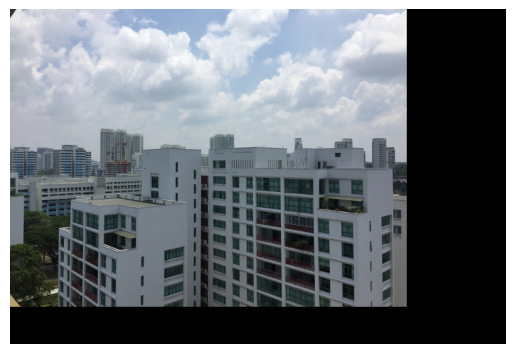

In [21]:
import matplotlib.pyplot as plt

# Create initial canvas
canvas = np.ones((540, 800, 3), dtype=np.uint8)
h1, w1 = img01.shape[:2]
canvas[:h1, :w1] = img01
plt.imshow(canvas)
plt.axis('off')
plt.show()

In [22]:

def enlargeCanvas(i, j, canvas):
    h, w= canvas.shape[:2]
    
    if i < 0:
        if j<0:
            new_canvas = np.ones((h + abs(i), w + abs(j), 3), dtype=np.uint8)
            new_canvas[abs(i): h+abs(i), abs(j):w+abs(j)] = canvas
            return new_canvas, 0, 0
        
        elif 0<=j<w:
            new_canvas = np.ones((h + abs(i), w, 3), dtype=np.uint8)
            new_canvas[abs(i): h+abs(i), 0:w] = canvas
            return new_canvas, 0, j
        
        elif j >=w:
            new_canvas = np.ones((h+abs(i), j+1, 3), dtype=np.uint8)
            new_canvas[abs(i): h+abs(i), 0:w] = canvas
            return new_canvas, 0, j
        
    if i >=h :
        if j < 0 :
            new_canvas = np.ones((i+1, w + abs(j), 3), dtype=np.uint8)
            new_canvas[0:h, abs(j):w+abs(j)] = canvas
            return new_canvas, i, 0
        elif 0 <= j <w:
            new_canvas = np.ones((i+1, w , 3), dtype=np.uint8)
            new_canvas[0:h, 0:w] = canvas
            return new_canvas, i, j
        elif j >=  w:
            new_canvas = np.ones((i+1, j , 3), dtype=np.uint8)
            new_canvas[0:h, 0:w] = canvas
            return new_canvas, i, j
        
    if 0<= i < h:
        if j<0:
            new_canvas = np.ones((h, abs(j)+w , 3), dtype=np.uint8)
            new_canvas[0:h, abs(j): abs(j)+ w] = canvas
            return new_canvas, i, 0
        elif j>=w:
            new_canvas = np.ones((h, j+1, 3), dtype=np.uint8)
            new_canvas[0:h, 0:w] = canvas
            return new_canvas, i, j
    return canvas, i, j
    
        

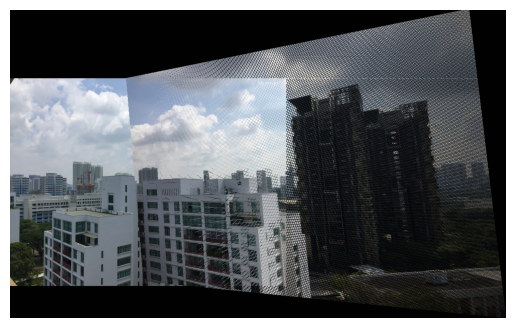

In [23]:
# Transform im02 to im01 using homography matrix

import matplotlib.pyplot as plt

height, width = img02.shape[:2]
transformed_img02 = np.ones((img01.shape[0], img01.shape[1], 3), dtype=img02.dtype)
min_h=0
max_h = canvas.shape[0]
min_w = 0
max_w = canvas.shape[1]

for x in range(height):
    for y in range(width):
        i,j,k = np.dot(H_21, [x, y, 1])
        i = int(i/ k)
        j = int(j/k)
        if min_h <= i < max_h and min_w <= j < max_w:
                canvas[i-min_h, j-min_w] = img02[x, y]
        else:
            m = i-min_h
            n = j-min_w
            if i < min_h:
                min_h = i
            if j < min_w:
                min_w = j
            if i > max_h:
                max_h = i
            if j > max_w:
                max_w = j
            
            canvas, i, j = enlargeCanvas(m, n, canvas)
            newshapeh, newshapew = canvas.shape[:2]
            canvas[i, j] = img02[x, y]
            
plt.imshow(canvas)
plt.axis('off')
plt.show()



### Method 2
 I firstly computed the coordinate of the edge of transformed img01. This is completed by using the edge point of img01, and multiply the homography H. 

 Then find the suitable size of canvs to hold all the points of transformed img01 and img02.
 
 Then for every point in the range of transformed img01, use the inverse of H to find the correspoinding points in img01. So that every pixel in the transformed img01 could have color.
 

In [24]:
def transform(img01, img02, H):
    # Transform img01 to img02, H is the homography matrix from img01 to img02

    # 1. Get the size of transformed img01 
    rec_points = [[0,0],[img01.shape[0], 0], [img01.shape[0], img01.shape[1]],[0, img01.shape[1]]]
    transformed_rec_points = []
    for point in rec_points:
        x = point[0]
        y = point[1]
        i,j,k = np.dot(H, [x, y, 1])
        i = int(i/ k)
        j = int(j/k)
        transformed_rec_points.append([i, j])

    # 2. Compute the size of canvas
    canvas_height = img02.shape[0]
    canvas_width = img02.shape[1]

    min_i = min(point[0] for point in transformed_rec_points)
    max_i = max(point[0] for point in transformed_rec_points)
    min_j = min(point[1] for point in transformed_rec_points)
    max_j = max(point[1] for point in transformed_rec_points)

    canvas_height = max(max_i, canvas_height) - min(0, min_i) + 1
    canvas_width = max(max_j, canvas_width) - min(0, min_j) + 1
    
    # 3. Create Canvas
    canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8)
    canvas[abs(min(0, min_i)): abs(min(0, min_i))+img02.shape[0], abs(min(0, min_j)): abs(min(0, min_j))+img02.shape[1]] = img02

    # 4. For every point in the size of transformed img01, use the inv of H to find the original point of img01
    for i in range(min_i, max_i):
        for j in range(min_j, max_j):
            x, y, z = np.dot(np.linalg.inv(H), [i, j, 1])
            x = int(x/z)
            y = int(y/z)
            if 0<=x< img01.shape[0] and 0<=y<img01.shape[1]:
                canvas[i + abs(min(0, min_i)), j + abs(min(0, min_j))] = img01[x,y]
    return canvas

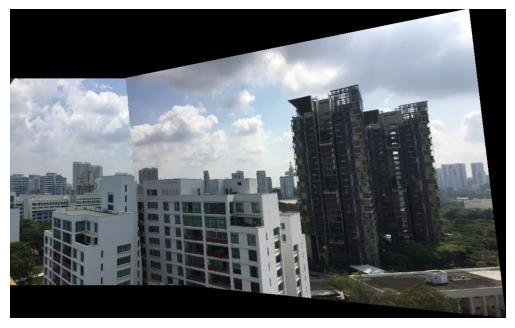

In [25]:
canvas = transform(img02, img01, H_21)
plt.imshow(canvas)
plt.axis('off')
plt.show()

3. Explain why there is an effect of double edges in the overlapping regions between im01.jpg and im02.jpg

- Image Registration Errors: Accurate feature detection and matching are critical for image stitching. Any errors in the registration of corresponding points can lead to misalignment and double edges.
- Parallax and Perspective Differences: When two images are taken from different viewpoints or angles, there can be perspective differences between them. These differences can lead to objects in the scene appearing at slightly different positions in each image. The homography matrix attempts to rectify these differences, but it cannot account for complex depth variations. As a result, some areas may not align perfectly, leading to double edges.
- Incomplete Scene Coverage: In some cases, the field of view in one image might be slightly wider or narrower than the other, causing a lack of corresponding features in the overlapping area. This can result in a portion of the scene not being properly aligned, leading to the double edge effect.